In [1]:
import torch, torchvision, PIL, numpy as np
import pathlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm.auto import tqdm
import pandas as pd
from google.colab import drive
import shutil
import os

Get images and data. Relevant files are found in the respository except the images, which are found here: https://drive.google.com/file/d/1-0yYrZAs-BoonZeXHhS5Cb5jWHzlNFvK/view?usp=sharing.

In [2]:
drive.mount('/content/drive')
with open(f'/content/drive/My Drive/CPEN 291 Datasets/Sports_Dataset/annotations_with_bbox.csv', 'r'):
  shutil.copy("/content/drive/My Drive/CPEN 291 Datasets/Sports_Dataset/annotations_with_bbox.csv", "annotations_with_bbox.csv")

dataset = pd.read_csv('annotations_with_bbox.csv')

with open('/content/drive/My Drive/CPEN 291 Datasets/Sports_Dataset/images.tar.gz', 'r'):
  shutil.copy('/content/drive/My Drive/CPEN 291 Datasets/Sports_Dataset/images.tar.gz', 'images.tar.gz')

drive.flush_and_unmount()

Mounted at /content/drive


In [3]:
!tar xfz images.tar.gz

In [4]:
dataset

,Unnamed: 0,id,x,y,w,h,label
0,0,015601864.jpg,653.204915,221.000000,7.795085,10.000000,1
1,1,015601864.jpg,584.734004,269.000000,62.531992,125.000000,1
2,2,015601864.jpg,638.038276,188.000000,22.961724,33.000000,2
3,3,015601864.jpg,549.408423,185.000000,66.591577,84.000000,2
4,4,015601864.jpg,573.000000,136.911589,119.000000,60.176823,3
...,...,...,...,...,...,...,...
127530,127530,025398745.jpg,879.486367,259.000000,63.513633,104.000000,2
127531,127531,025398745.jpg,868.288729,118.000000,102.711271,141.000000,3
127532,127532,025398745.jpg,871.000000,165.000000,46.000000,63.000000,4
127533,127533,025398745.jpg,894.986986,118.000000,24.026028,47.000000,5


Found some unexpected data anomalies when training so they need to be removed.

In [5]:
w_0 = dataset[dataset['w'] == 0]
w_0

,Unnamed: 0,id,x,y,w,h,label
65625,65625,016983943.jpg,743.0,72.0,0.0,0.0,6
77340,77340,068839670.jpg,1782.0,660.0,0.0,0.0,6
105330,105330,007261085.jpg,756.0,260.0,0.0,0.0,6


In [6]:
h_0 = dataset[dataset['h'] == 0]
h_0

,Unnamed: 0,id,x,y,w,h,label
65625,65625,016983943.jpg,743.0,72.0,0.0,0.0,6
77340,77340,068839670.jpg,1782.0,660.0,0.0,0.0,6
105330,105330,007261085.jpg,756.0,260.0,0.0,0.0,6


In [7]:
dataset.drop([65625, 77340, 105330], inplace=True)

Second dataset, images here: https://drive.google.com/file/d/1-4z-UM1Hci1gLPp00Uh3_YIjMG8u12vt/view?usp=sharing

In [8]:
drive.mount('/content/drive')
with open('/content/drive/My Drive/CPEN 291 Datasets/Tracking_Dataset/2nd_dataset.csv', 'r'):
  shutil.copy("/content/drive/My Drive/CPEN 291 Datasets/Tracking_Dataset/2nd_dataset.csv", "2nd_dataset.csv")

dataset2 = pd.read_csv('2nd_dataset.csv')

with open('/content/drive/My Drive/CPEN 291 Datasets/Tracking_Dataset/dataset2.tar.gz', 'r'):
  shutil.copy('/content/drive/My Drive/CPEN 291 Datasets/Tracking_Dataset/dataset2.tar.gz', 'dataset2.tar.gz')

drive.flush_and_unmount()

Mounted at /content/drive


In [9]:
!tar xfz dataset2.tar.gz

In [10]:
!mv dataset images_2

In [11]:
print(len(os.listdir('images_2')))
print(len(dataset2))
print(len(dataset2["image"].unique()))

7490
7490
7490


In [12]:
dataset2.columns = ['Unnamed: 0', 'id', 'x', 'y', 'w', 'h', 'label']
dataset2

,Unnamed: 0,id,x,y,w,h,label
0,0,ball0040.jpg,200.34,113.73,45.13,45.59,7
1,1,ball0037.jpg,202.39,113.73,44.68,45.59,7
2,2,ball0254.jpg,203.30,113.73,44.68,45.13,7
3,3,ball0300.jpg,203.30,114.19,44.68,44.90,7
4,4,ball0021.jpg,201.94,114.19,45.35,45.58,7
...,...,...,...,...,...,...,...
7485,7570,dog-toy2292.jpg,225.00,145.00,34.00,56.00,16
7486,7571,dog-toy2293.jpg,223.00,151.00,34.00,56.00,16
7487,7572,dog-toy2294.jpg,221.00,157.00,34.00,57.00,16
7488,7573,dog-toy2295.jpg,219.00,164.00,34.00,57.00,16


Get some Pytorch reference code to make things easier.

In [13]:
%%shell

git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 2407, done.
remote: Counting objects: 100% (2407/2407), done.
remote: Compressing objects: 100% (524/524), done.
remote: Total 21019 (delta 1882), reused 2297 (delta 1823), pack-reused 18612
Receiving objects: 100% (21019/21019), 21.69 MiB | 25.74 MiB/s, done.
Resolving deltas: 100% (15433/15433), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version


In [14]:
import utils

Create the dataset class.

In [15]:
class DetectionDataset(torch.utils.data.Dataset):
  def __init__(self, df, image_dir, transform=None):
    super().__init__()

    self.df = df
    self.image_ids = self.df['id'].unique()
    self.image_dir = pathlib.Path(image_dir).resolve()
    self.transform = transform
  
  def __getitem__(self, idx):
    image_id = self.image_ids[idx]
    records = self.df[self.df['id'] == image_id]
    im = PIL.Image.open(self.image_dir/image_id).convert('RGB')
    im_width_orig, im_height_orig = im.size
    # im = torchvision.transforms.ToTensor()(im)
    if self.transform is not None:
      im = self.transform(im)

    if isinstance(im, torch.Tensor):
      im_height_new = im.size()[1]
      im_width_new = im.size()[2]
    else:
      im_width_new, im_height_new = im.size
    # ratios for resizing the image bounding box coordinates
    rx = im_width_new / im_width_orig
    ry = im_height_new / im_height_orig
    # bounding box coordinates are stored with width and height while we want an endpoint
    boxes = records[['x', 'y', 'w', 'h']].values
    boxes[:, 0] *= rx
    boxes[:, 1] *= ry
    boxes[:, 2] *= rx
    boxes[:, 3] *= ry
    boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
    boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    area = (boxes[:,3] - boxes[:,1]) * (boxes[:,2] - boxes[:,0])
    labels = torch.tensor(records['label'].values)

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["image_id"] = torch.tensor([idx])
    target["area"] = area
    target["iscrowd"] = torch.zeros((len(boxes),), dtype=torch.int64) #Assume all are not crowded
    
    return im, target

  def __len__(self):
    return self.image_ids.shape[0]

In [16]:
dataset_full = DetectionDataset(dataset, 'images_data', torchvision.transforms.ToTensor())

In [17]:
dataset_full[0]

(tensor([[[0.0078, 0.0078, 0.0039,  ..., 0.0078, 0.0078, 0.0078],
          [0.0118, 0.0118, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
          [0.0431, 0.0510, 0.0510,  ..., 0.0275, 0.0314, 0.0392],
          ...,
          [0.5843, 0.5882, 0.5882,  ..., 0.0078, 0.0078, 0.0078],
          [0.0078, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0314, 0.0314, 0.0235,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0039, 0.0039, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
          [0.0118, 0.0118, 0.0118,  ..., 0.0039, 0.0039, 0.0039],
          [0.0706, 0.0706, 0.0667,  ..., 0.0314, 0.0353, 0.0314],
          ...,
          [0.5804, 0.5843, 0.5843,  ..., 0.0196, 0.0196, 0.0196],
          [0.0039, 0.0000, 0.0000,  ..., 0.0078, 0.0078, 0.0078],
          [0.0275, 0.0275, 0.0196,  ..., 0.0078, 0.0078, 0.0078]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0118, 0.0196,  ..., 0.0353, 0.0353, 0.0353],
          [0.0941, 0.0941, 0.1098,  ...,

In [18]:
print(dataset.loc[0])

Unnamed: 0                0
id            015601864.jpg
x                   653.205
y                       221
w                   7.79508
h                        10
label                     1
Name: 0, dtype: object


Now to check how it looks as a picture instead of just numbers.

In [19]:
classes = {
    1: 'shin',
    2: 'thigh',
    3: 'torso',
    4: 'forearm',
    5: 'uparm',
    6: 'head',
    7: 'ball',
    8: 'cup',
    9: 'juice',
    10: 'rubikscube',
    11: 'hand',
    12: 'bird',
    13: 'motorcycle',
    14: 'bike',
    15: 'car',
    16: 'toy-dog'
}

In [20]:
def show_img(img, title=None):
  if torch.is_tensor(img):
    img = img.cpu().permute(1,2,0)
  plt.imshow(img)
  if title:
    plt.title(title, color='w')
  plt.axis('off')

def show_boxes(img, sample, classes=None):
  show_img(img)
  ax = plt.gca()
  boxes = sample['boxes']
  labels = sample['labels']
  xmin, xmax = ax.get_xlim()
  ymax, ymin = ax.get_ylim()
  isx, isy = xmax-xmin, ymax-ymin
  for i in range(boxes.shape[0]):
    box = boxes[i]
    label = labels[i]
    # x = max(xmin, box[0])
    # y = max(ymin, box[1])
    # w = min(box[2] - x, xmax - x)
    # h = min(box[3] - y, ymax - y)
    # x = xmin + isx * box[0]
    # y = ymin + isy * box[1]
    # w = isx * (box[2] - box[0])
    # h = isy * (box[3] - box[1])
    x = box[0]
    y = box[1]
    w = box[2] - x
    h = box[3] - y
    bbox = patches.Rectangle((x, y), w, h, ec='r', fc='none')
    ax.add_patch(bbox)
    if classes:
      plt.text(x, y, classes[label.item()], backgroundcolor='r', c='w')


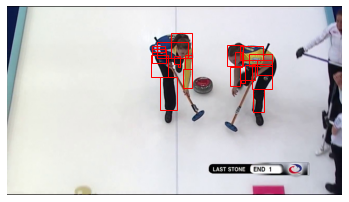

In [21]:
im, result = dataset_full[0]

show_boxes(im, result) #plotting with labels makes it impossible to see


Test transforms.

In [22]:
xform = torchvision.transforms.Compose([torchvision.transforms.Resize((240,426)), torchvision.transforms.ToTensor()])
dataset_full = DetectionDataset(dataset, 'images_data', xform)
dataset_full[0]

(tensor([[[0.0275, 0.0235, 0.0196,  ..., 0.0196, 0.0235, 0.0196],
          [0.0549, 0.0549, 0.0549,  ..., 0.0549, 0.0549, 0.0549],
          [0.0549, 0.0549, 0.0549,  ..., 0.0627, 0.0627, 0.0627],
          ...,
          [0.9294, 0.9333, 0.9333,  ..., 0.0588, 0.0588, 0.0588],
          [0.8980, 0.9059, 0.9020,  ..., 0.0431, 0.0431, 0.0431],
          [0.2784, 0.2784, 0.2824,  ..., 0.0078, 0.0078, 0.0078]],
 
         [[0.0392, 0.0353, 0.0314,  ..., 0.0196, 0.0235, 0.0235],
          [0.1059, 0.1020, 0.0980,  ..., 0.0824, 0.0824, 0.0824],
          [0.1020, 0.0980, 0.0902,  ..., 0.1059, 0.1059, 0.1059],
          ...,
          [0.9255, 0.9294, 0.9294,  ..., 0.0706, 0.0706, 0.0706],
          [0.8941, 0.9020, 0.8980,  ..., 0.0549, 0.0549, 0.0549],
          [0.2745, 0.2745, 0.2824,  ..., 0.0157, 0.0157, 0.0157]],
 
         [[0.0549, 0.0824, 0.1059,  ..., 0.0745, 0.0745, 0.0706],
          [0.2000, 0.2353, 0.2510,  ..., 0.2510, 0.2510, 0.2510],
          [0.2078, 0.2392, 0.2667,  ...,

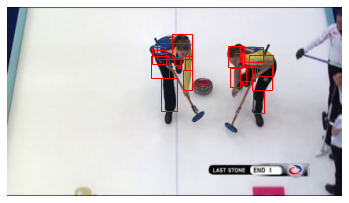

In [23]:
im, result = dataset_full[0]

show_boxes(im, result)

In [24]:
im.size()

torch.Size([3, 240, 426])

That looks good, now to combine the datasets.

In [25]:
dataset_comb = dataset.append(dataset2, ignore_index=True)


In [26]:
dataset_comb

,Unnamed: 0,id,x,y,w,h,label
0,0,015601864.jpg,653.204915,221.000000,7.795085,10.000000,1
1,1,015601864.jpg,584.734004,269.000000,62.531992,125.000000,1
2,2,015601864.jpg,638.038276,188.000000,22.961724,33.000000,2
3,3,015601864.jpg,549.408423,185.000000,66.591577,84.000000,2
4,4,015601864.jpg,573.000000,136.911589,119.000000,60.176823,3
...,...,...,...,...,...,...,...
135017,7570,dog-toy2292.jpg,225.000000,145.000000,34.000000,56.000000,16
135018,7571,dog-toy2293.jpg,223.000000,151.000000,34.000000,56.000000,16
135019,7572,dog-toy2294.jpg,221.000000,157.000000,34.000000,57.000000,16
135020,7573,dog-toy2295.jpg,219.000000,164.000000,34.000000,57.000000,16


In [27]:
dataset_comb.drop(labels="Unnamed: 0", axis='columns')

,id,x,y,w,h,label
0,015601864.jpg,653.204915,221.000000,7.795085,10.000000,1
1,015601864.jpg,584.734004,269.000000,62.531992,125.000000,1
2,015601864.jpg,638.038276,188.000000,22.961724,33.000000,2
3,015601864.jpg,549.408423,185.000000,66.591577,84.000000,2
4,015601864.jpg,573.000000,136.911589,119.000000,60.176823,3
...,...,...,...,...,...,...
135017,dog-toy2292.jpg,225.000000,145.000000,34.000000,56.000000,16
135018,dog-toy2293.jpg,223.000000,151.000000,34.000000,56.000000,16
135019,dog-toy2294.jpg,221.000000,157.000000,34.000000,57.000000,16
135020,dog-toy2295.jpg,219.000000,164.000000,34.000000,57.000000,16


Combine the image folders.

In [28]:
!mkdir images_full

In [29]:
for fn in os.listdir('images_data'):
  shutil.copy(f'images_data/{fn}', f'images_full/{fn}')
for fn in os.listdir('images_2'):
  shutil.copy(f'images_2/{fn}', f'images_full/{fn}')

In [30]:
print(len(os.listdir('images_full')))
print(len(dataset_comb['id'].unique()))

16542
16542


In [41]:
dataset_full = DetectionDataset(dataset_comb, 'images_full', xform)

Now to make the actual model.

In [32]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
def get_FRCNN_model(num_classes):
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

  in_features = model.roi_heads.box_predictor.cls_score.in_features

  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

  return model

In [42]:
model = get_FRCNN_model(len(classes)+1) #+1 because of background being class 0

In [43]:
device = torch.device('cuda:0')
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [44]:
n_all = len(dataset_full)
n_used = int(1 * n_all)
n_train = int(0.8 * n_used)
n_test = n_used - n_train
rng = torch.Generator().manual_seed(291)


In [45]:
#Note, dataset 1 is much larger than 2 so the split is likely very imbalanced. Look into later.
dataset_train, dataset_test, _ = torch.utils.data.random_split(dataset_full, [n_train, n_test, n_all-n_train-n_test], rng)

In [46]:
#Annoying problem with batch_size where batch_size > 1 won't work because there are different # of detections in each image and tensors can't be stacked
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=1, shuffle=True, collate_fn=utils.collate_fn)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=utils.collate_fn)

In [47]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

Finally, training.

In [39]:
from engine import train_one_epoch, evaluate

In [48]:
num_epochs = 5

for epoch in range(num_epochs):
  train_one_epoch(model, optimizer, loader_train, device, epoch, print_freq=1000)
  scheduler.step()
  evaluate(model, loader_test, device=device)

Epoch: [0]  [    0/13233]  eta: 1:34:28  lr: 0.000010  loss: 3.5608 (3.5608)  loss_classifier: 3.4423 (3.4423)  loss_box_reg: 0.0568 (0.0568)  loss_objectness: 0.0505 (0.0505)  loss_rpn_box_reg: 0.0111 (0.0111)  time: 0.4283  data: 0.0370  max mem: 2408
Epoch: [0]  [ 1000/13233]  eta: 1:09:25  lr: 0.005000  loss: 1.0737 (0.9555)  loss_classifier: 0.3905 (0.4422)  loss_box_reg: 0.4040 (0.3432)  loss_objectness: 0.0737 (0.1136)  loss_rpn_box_reg: 0.0261 (0.0565)  time: 0.3438  data: 0.0292  max mem: 2412
Epoch: [0]  [ 2000/13233]  eta: 1:03:42  lr: 0.005000  loss: 1.1473 (0.8836)  loss_classifier: 0.4654 (0.3893)  loss_box_reg: 0.5054 (0.3451)  loss_objectness: 0.0610 (0.0956)  loss_rpn_box_reg: 0.0405 (0.0536)  time: 0.3450  data: 0.0321  max mem: 2412
Epoch: [0]  [ 3000/13233]  eta: 0:58:02  lr: 0.005000  loss: 0.3859 (0.8478)  loss_classifier: 0.2473 (0.3663)  loss_box_reg: 0.1641 (0.3393)  loss_objectness: 0.0342 (0.0906)  loss_rpn_box_reg: 0.0064 (0.0515)  time: 0.3378  data: 0.0246

KeyboardInterrupt: ignored

In [49]:
torch.save(model.state_dict(), "model1.pt")

In [50]:
from google.colab import files
files.download("model1.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>